In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from rdkit import Chem
from rdkit.Chem import AllChem

pd.set_option('display.max_colwidth', None)
RandomSeed = 42
np.random.seed(RandomSeed)

# Data

In [3]:
#Read in data already with pre-computed Autodock Vina descriptors for exp. crystal structures:
full_df = pd.read_csv('Data/autodock_vina_structures.csv', sep = '\t')

In [5]:
#Allocate labels:
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)
df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df4], axis = 0)

<ipython-input-5-f13cdb822809>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-5-f13cdb822809>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-5-f13cdb822809>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [6]:
#Correct IC50 value for one of the compounds where we know it was measured incorrectly:
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore covalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]

#Replace all inactives with an IC50 value of 100 for now:
df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 

In [7]:
#Reduce down to only relevant columns:
columns_choose = ['Compound ID', 'SMILES', 'Library', 'Postera series', 'protein_filename', 'ligand_filename',
                  '0', '1', '2', '3', '4', '5', 'category', 'p_IC50']
df_comb_all = df_comb_all[columns_choose]  

In [8]:
docking_data_ADV = pd.read_csv('Data/autodock_vina_docking.csv')
docking_data_ADV = docking_data_ADV.rename(columns = {'0': '0_d', '1': '1_d', '2': '2_d', '3': '3_d',
                                                      '4': '4_d', '5': '5_d'})
df_comb_all = df_comb_all.merge(docking_data_ADV[['Compound ID', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d']],
                               left_on = 'Compound ID', right_on = 'Compound ID')

In [9]:
#Add also Morgan fingerprints for each compound:
df_comb_all['FP'] = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2, nBits=512).ToBitString() for x in df_comb_all['SMILES']]
df_comb_all = df_comb_all.reset_index(drop = True)
FP_array = np.zeros((df_comb_all.shape[0], 512))
for i in range(0, df_comb_all.shape[0]):
    FP_array[i,:] = list(df_comb_all['FP'].iloc[i])
df_FP = pd.DataFrame(FP_array)  
df_FP = df_FP.add_suffix('_Mgn')
df_comb_all = pd.concat([df_comb_all, df_FP], axis = 1)
df_comb_all = df_comb_all.drop(columns = 'FP')


In [10]:
#Map timestamps & scaffolds
metadata = pd.read_csv('Data/metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)

timestamps = pd.read_csv('Data/Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)


In [11]:
#Focus analysis on only these scaffolds:
scaffold_keep = ['Aminopyridine-like', 'Isoquinoline', 'Benzotriazole', 'Quinolone']
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]

In [12]:
df_comb_all.to_csv('Data/DATA_with_all_FEATURES.csv')

In [21]:
import seaborn as sns

/opt/miniconda3/envs/bedtools1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='p_IC50', ylabel='Density'>

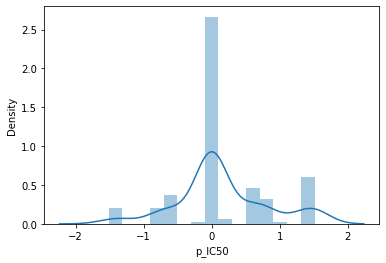

In [22]:
sns.distplot(train_data_diff_all['p_IC50'])

In [13]:
df_comb_all = df_comb_all.sort_values(by = 'date')


In [15]:
#model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
columns = feature_columns + label 
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

split = [0.1, 0.3, 0.5, 0.7, 0.9]
train_aucs = []; test_aucs = []
for k in range(0, len(split)):
    train_size = int(split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix = np.array(test_aucs).reshape(len(split), boostrap)
test_auc_bootstrap = np.mean(test_aucs_matrix, axis = 1)
test_auc_bootstrap_std = np.std(test_aucs_matrix, axis = 1)

NameError: name 'model' is not defined

In [4]:

model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
split = [0.1, 0.3, 0.5, 0.7, 0.9]
train_aucs_MFP = []; test_aucs_MFP = []


split = [0.1, 0.3, 0.5, 0.7, 0.9]
train_aucs_MFP = []; test_aucs_MFP = []
for k in range(0, len(split)):
    train_size = int(split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs_MFP.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs_MFP.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_MFP = np.array(test_aucs_MFP).reshape(len(split), boostrap)
test_auc_bootstrap_MFP = np.mean(test_aucs_matrix_MFP, axis = 1)
test_auc_bootstrap_MFP_std = np.std(test_aucs_matrix_MFP, axis = 1)

<ipython-input-4-f8f7ddc3673e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-4-f8f7ddc3673e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-4-f8f7ddc3673e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

(330, 30)
(235, 30)
(202, 34)
Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            503,      504,      505,      506,      507,      508,      509,
            510,      511, 'p_IC50'],
      dtype='object', length=513)


In [5]:
#Docked structures:
#For docking results:
combined_results = pd.read_csv('docking_oddt.csv')
combined_results['name'] = combined_results['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
combined_results['scaffold'] = combined_results['name'].map(scaffold_dict)
df_comb_all = combined_results.copy()

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')

metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all.reset_index(drop = True)
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]


model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
ID = ['Compound ID', 'date']
columns = feature_columns + label + ID 
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.sort_values(by = 'date')
df_analyse = df_analyse.drop(columns = ['Compound ID', 'date'])
df_analyse = df_analyse.reset_index(drop = True)

split = [0.1, 0.3, 0.5, 0.7, 0.9]
train_aucs_dock = []; test_aucs_dock = []
for k in range(0, len(split)):
    train_size = int(split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs_dock.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs_dock.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_dock = np.array(test_aucs_dock).reshape(len(split), boostrap)
test_auc_bootstrap_dock = np.mean(test_aucs_matrix_dock, axis = 1)
test_auc_bootstrap_dock_std = np.std(test_aucs_matrix_dock, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


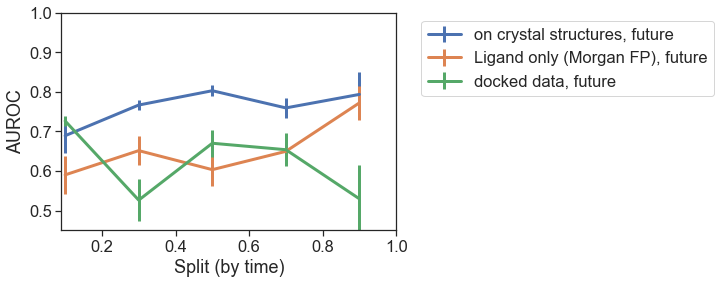

In [64]:
sns.set(font_scale=1.5) 
sns.set_style("ticks")
#plt.plot(split, train_aucs, label = 'on crystal structures, existing', linewidth = 2)
#plt.plot(split, train_aucs_dock, label = 'docked data, existing', linewidth = 2)
#plt.plot(split, train_aucs_MFP, label = 'MFP, existing', linewidth = 2)
plt.errorbar(split, test_auc_bootstrap, yerr = test_auc_bootstrap_std, label = 'on crystal structures, future', linewidth = 3)
plt.errorbar(split, test_auc_bootstrap_MFP, yerr = test_auc_bootstrap_MFP_std, label = 'Ligand only (Morgan FP), future', linewidth = 3)
plt.errorbar(split, test_auc_bootstrap_dock, yerr = test_auc_bootstrap_dock_std, label = 'docked data, future', linewidth = 3)
plt.xlim([0.09, 1])
plt.ylim([0.45, 1])
plt.xlabel('Split (by time)')
plt.ylabel('AUROC')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
plt.savefig('predict_future_5fold-btsp_RS42.pdf')
plt.show()

# Same analysis but now with scaffold-split in addition to time-split:

In [44]:
#Crystal structures:
full_df = pd.read_csv('autodock_vina_descriptors.csv', sep = '\t')
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)

df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df3, df4], axis = 0)

#Correct IC50 value for one of the compounds
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore covalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]
df_comb_all = df_comb_all[df_comb_all['category'] != 'unknown']

df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 
df_comb_all = df_comb_all.drop(columns = ['Fluorescence avg IC50 (uM)', 'IC50'])

#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]
print(df_comb_all.shape)


(202, 40)


<ipython-input-44-6e6adb64ab24>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-44-6e6adb64ab24>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-44-6e6adb64ab24>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [45]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

boostrap = 100
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5 = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5 = np.mean(test_aucs_matrix_sc_bs5, axis = 1)
test_auc_bootstrap_std_sc_bs5 = np.std(test_aucs_matrix_sc_bs5, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


In [46]:
#With Morgan FP
full_df = pd.read_csv('autodock_vina_descriptors.csv', sep = '\t')
full_df = full_df.drop(columns = ['0', '1', '2', '3', '4', '5'])
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)

df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df3, df4], axis = 0)

#Correct IC50 value for one of the compounds
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore coavalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
print(df_comb_all.shape)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]
df_comb_all = df_comb_all[df_comb_all['category'] != 'unknown']
print(df_comb_all.shape)

df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 
df_comb_all = df_comb_all.drop(columns = ['Fluorescence avg IC50 (uM)', 'IC50'])


#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all.reset_index(drop = True)

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]
print(df_comb_all.shape)

df_comb_all['FP'] = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2, nBits=512).ToBitString() for x in df_comb_all['SMILES']]
df_comb_all = df_comb_all.reset_index(drop = True)
feature_columns = ['FP']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)
FP_array = np.zeros((df_comb_all.shape[0], 512))
for i in range(0, df_comb_all.shape[0]):
    FP_array[i,:] = list(df_comb_all['FP'].iloc[i])
df_FP = pd.DataFrame(FP_array)  
df_analyse = pd.concat([df_FP, df_analyse], axis = 1)
df_analyse = df_analyse.drop(columns = 'FP')
df_analyse = df_analyse.reset_index(drop = True)


(330, 30)
(235, 30)
(202, 34)


<ipython-input-46-0d12eded3c0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-46-0d12eded3c0d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-46-0d12eded3c0d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [47]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
boostrap = 100
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5_MFP = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5_MFP = np.mean(test_aucs_matrix_sc_bs5_MFP, axis = 1)
test_auc_bootstrap_std_sc_bs5_MFP = np.std(test_aucs_matrix_sc_bs5_MFP, axis = 1)

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            503,      504,      505,      506,      507,      508,      509,
            510,      511, 'p_IC50'],
      dtype='object', length=513)


In [48]:
#Docked structures:
#For docking results:
combined_results = pd.read_csv('docking_oddt.csv')
combined_results['name'] = combined_results['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
combined_results['scaffold'] = combined_results['name'].map(scaffold_dict)
df_comb_all = combined_results.copy()

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')

metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all.reset_index(drop = True)
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]


model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

In [49]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)

boostrap = 100
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5_dock = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5_dock = np.mean(test_aucs_matrix_sc_bs5_dock, axis = 1)
test_auc_bootstrap_dock_std = np.std(test_aucs_matrix_sc_bs5_dock, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


In [50]:
#Hybrid where we learn from crystal structures and predict on experimental structures

#Crystal structures:
full_df = pd.read_csv('autodock_vina_descriptors.csv', sep = '\t')
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)

df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df3, df4], axis = 0)

#Correct IC50 value for one of the compounds
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore covalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]
df_comb_all = df_comb_all[df_comb_all['category'] != 'unknown']

df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 
df_comb_all = df_comb_all.drop(columns = ['Fluorescence avg IC50 (uM)', 'IC50'])

#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]
print(df_comb_all.shape)

combined_results = pd.read_csv('docking_oddt.csv')
combined_results['name'] = combined_results['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
combined_results['scaffold'] = combined_results['name'].map(scaffold_dict)
combined_results = combined_results.rename(columns = {'0': '0_d', '1': '1_d', '2': '2_d', '3': '3_d',
                                   '4': '4_d', '5': '5_d'})
df_comb_all = df_comb_all.merge(combined_results[['0_d', '1_d', '2_d', '3_d',
                                                 '4_d', '5_d', 'Compound ID']], left_on = 'Compound ID', right_on = 'Compound ID')



(202, 40)


<ipython-input-50-95a94653e744>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-50-95a94653e744>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-50-95a94653e744>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [51]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

In [52]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
boostrap = 100
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold', '0_d', '1_d', '2_d', '3_d', '4_d', '5_d'])
    test_data = test_data.drop(columns = ['scaffold', '0', '1', '2', '3', '4', '5'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5_hybrid = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5_hybrid = np.mean(test_aucs_matrix_sc_bs5_hybrid, axis = 1)
test_auc_bootstrap_std_sc_bs5_hybrid = np.std(test_aucs_matrix_sc_bs5_hybrid, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


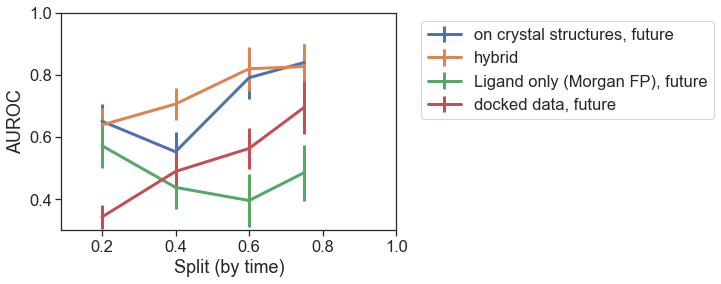

In [54]:
sns.set(font_scale=1.5) 
sns.set_style("ticks")
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5, yerr = test_auc_bootstrap_std_sc_bs5 / np.sqrt(3),
             label = 'on crystal structures, future', linewidth = 3)
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5_hybrid, yerr = test_auc_bootstrap_std_sc_bs5_hybrid / np.sqrt(3),
             label = 'hybrid', linewidth = 3)
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5_MFP, yerr = test_auc_bootstrap_std_sc_bs5_MFP / np.sqrt(3),
             label = 'Ligand only (Morgan FP), future', linewidth = 3)
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5_dock, yerr = test_auc_bootstrap_dock_std / np.sqrt(3),
             label = 'docked data, future', linewidth = 3)
plt.xlim([0.09, 1])
plt.ylim([0.3, 1])
plt.xlabel('Split (by time)')
plt.ylabel('AUROC')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
plt.savefig('predict_future_100fold-btsp_scfld_split.pdf')
plt.show()

# Same results but without requiring scaffold split

In [5]:
#Crystal structures:
full_df = pd.read_csv('autodock_vina_descriptors.csv', sep = '\t')
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)

df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df3, df4], axis = 0)

#Correct IC50 value for one of the compounds
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore covalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]
df_comb_all = df_comb_all[df_comb_all['category'] != 'unknown']

df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 
df_comb_all = df_comb_all.drop(columns = ['Fluorescence avg IC50 (uM)', 'IC50'])

#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]
print(df_comb_all.shape)


(202, 40)


<ipython-input-5-6e6adb64ab24>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-5-6e6adb64ab24>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-5-6e6adb64ab24>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [6]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

boostrap = 20
time_split = [0.2, 0.4, 0.6, 0.8]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    #train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    #test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5 = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5 = np.mean(test_aucs_matrix_sc_bs5, axis = 1)
test_auc_bootstrap_std_sc_bs5 = np.std(test_aucs_matrix_sc_bs5, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


In [11]:
#With Morgan FP
full_df = pd.read_csv('autodock_vina_descriptors.csv', sep = '\t')
full_df = full_df.drop(columns = ['0', '1', '2', '3', '4', '5'])
df1 = full_df[full_df['Fluorescence avg IC50 (uM)'] < 50]
leftover1 = pd.concat([full_df, df1, df1]).drop_duplicates(keep=False)
df2 = leftover1[leftover1['Fluorescence avg IC50 (uM)'] > 50]
leftover2 = pd.concat([leftover1, df2, df2]).drop_duplicates(keep=False)
df3 = leftover2[leftover2['Fluorescence inhibition at 50 uM'].isna()]
df4 = pd.concat([leftover2, df3, df3]).drop_duplicates(keep=False)

df1['category'] = 'active'
df2['category'] = 'inactive'
df3['category'] = 'unknown'
df4['category'] = 'inactive'
df_comb_all = pd.concat([df1, df2, df3, df4], axis = 0)

#Correct IC50 value for one of the compounds
df_comb_all['Fluorescence avg IC50 (uM)'] = np.where(df_comb_all['Compound ID'] == 'VLA-UCB-1dbca3b4-15',
                                0.14, df_comb_all['Fluorescence avg IC50 (uM)'])
#Ignore coavalent binders (identified manually from the crystallography data looking at compoudns with IC50 up to 1.6uM)
print(df_comb_all.shape)
df_comb_all = df_comb_all[~df_comb_all['Compound ID'].isin(['ALP-POS-c59291d4-5',
            'JAG-UCB-a3ef7265-20', 'MAT-POS-fa06b69f-6', 'BEN-DND-93268d01-8'])]
df_comb_all = df_comb_all[df_comb_all['category'] != 'unknown']
print(df_comb_all.shape)

df_comb_all['IC50'] =  np.where(df_comb_all['category'] == 'active', df_comb_all['Fluorescence avg IC50 (uM)'], 100)
df_comb_all['p_IC50'] = 6 - np.log10(df_comb_all['IC50']) 
df_comb_all = df_comb_all.drop(columns = ['Fluorescence avg IC50 (uM)', 'IC50'])


#FOR ODDT & for MFPs:
metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all.reset_index(drop = True)

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]
print(df_comb_all.shape)

df_comb_all['FP'] = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2, nBits=512).ToBitString() for x in df_comb_all['SMILES']]
df_comb_all = df_comb_all.reset_index(drop = True)
feature_columns = ['FP']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)
FP_array = np.zeros((df_comb_all.shape[0], 512))
for i in range(0, df_comb_all.shape[0]):
    FP_array[i,:] = list(df_comb_all['FP'].iloc[i])
df_FP = pd.DataFrame(FP_array)  
df_analyse = pd.concat([df_FP, df_analyse], axis = 1)
df_analyse = df_analyse.drop(columns = 'FP')
df_analyse = df_analyse.reset_index(drop = True)


(330, 30)
(235, 30)
(202, 34)


<ipython-input-11-0d12eded3c0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['category'] = 'active'
<ipython-input-11-0d12eded3c0d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['category'] = 'inactive'
<ipython-input-11-0d12eded3c0d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [16]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 'sqrt', random_state = 0)
boostrap = 10
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    #train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    #test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5_MFP = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5_MFP = np.mean(test_aucs_matrix_sc_bs5_MFP, axis = 1)
test_auc_bootstrap_std_sc_bs5_MFP = np.std(test_aucs_matrix_sc_bs5_MFP, axis = 1)

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            503,      504,      505,      506,      507,      508,      509,
            510,      511, 'p_IC50'],
      dtype='object', length=513)


In [7]:
#Docked structures:
#For docking results:
combined_results = pd.read_csv('docking_oddt.csv')
combined_results['name'] = combined_results['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
combined_results['scaffold'] = combined_results['name'].map(scaffold_dict)
df_comb_all = combined_results.copy()

timestamps = pd.read_csv('Time_stamps/moonshot_submissions_data_for_alpha.csv')
df_comb_all['Compound_ID_1_short'] = np.where(df_comb_all['Compound ID'].str[-2] == '-', df_comb_all['Compound ID'].str[:-2], '')
df_comb_all['Compound_ID_2_short'] = np.where(df_comb_all['Compound ID'].str[-3] == '-', df_comb_all['Compound ID'].str[:-3], '')
df_comb_all['Compound_ID_short'] = df_comb_all['Compound_ID_1_short'] + df_comb_all['Compound_ID_2_short']
df_comb_all = df_comb_all.drop(columns = ['Compound_ID_1_short', 'Compound_ID_2_short'])
date_map = dict(zip(timestamps['submission_id'], timestamps['date']))
df_comb_all['date'] = df_comb_all['Compound_ID_short'].map(date_map)
df_comb_all = df_comb_all.sort_values(by = 'date')

metadata = pd.read_csv('metadata.csv')
df_comb_all['name'] = df_comb_all['ligand_filename'].str.split('/').str[-1].str.split('.sdf').str[0]
scaffold_dict = dict(zip(metadata['crystal_name'], metadata['site_name']))
df_comb_all['scaffold'] = df_comb_all['name'].map(scaffold_dict)
df_comb_all = df_comb_all.reset_index(drop = True)
df_comb_all = df_comb_all[df_comb_all['scaffold'].isin(scaffold_keep)]


model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)
feature_columns = ['0', '1', '2', '3', '4', '5']
label = ['p_IC50']
inf_columns = ['scaffold']
columns = feature_columns + label + inf_columns
df_analyse = df_comb_all[columns]
df_analyse = df_analyse.reset_index(drop = True)

In [8]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 5, max_features = 'sqrt', random_state = 0)

boostrap = 100
time_split = [0.2, 0.4, 0.6, 0.75]
train_aucs = []; test_aucs = []
for k in range(0, len(time_split)):
    train_size = int(time_split[k] * df_analyse.shape[0])
    train_data = df_analyse.iloc[0:train_size]
    test_data = df_analyse.iloc[train_size:df_analyse.shape[0]]
    #train_data = train_data[train_data['scaffold'].isin(['Aminopyridine-like', 'Isoquinoline'])]
    #test_data = test_data[test_data['scaffold'].isin(['Benzotriazole', 'Quinolone'])]
    train_data = train_data.drop(columns = ['scaffold'])
    test_data = test_data.drop(columns = ['scaffold'])
    
    train_data_diff = pd.DataFrame()
    for i in range(1, train_data.shape[0]):
        train_data_diff_add = train_data.diff(periods = i).dropna()
        train_data_diff = pd.concat([train_data_diff, train_data_diff_add], axis = 0)
    train_data_diff_all = train_data_diff.copy()
    train_data_diff = train_data_diff_all[(train_data_diff_all['p_IC50'] > 0.25)  | (train_data_diff_all['p_IC50'] < -0.25)]
    train_data_diff = train_data_diff.reset_index(drop = True)

    train_labels = train_data_diff['p_IC50']
    train_features = train_data_diff.drop(columns = ['p_IC50'])
    train_labels_comparison = pd.Series(np.where(train_labels > 0, 0, 1))
    model.fit(train_features, train_labels_comparison)
    test_data_start = test_data.copy()
    
    for j in range(0, boostrap):
        test_data = resample(test_data_start, replace=True, n_samples = test_data.shape[0], random_state=j)
        test_data_diff = pd.DataFrame()
        for i in range(1, test_data.shape[0]):
            test_data_diff_add = test_data.diff(periods = i).dropna()
            test_data_diff = pd.concat([test_data_diff, test_data_diff_add], axis = 0)
        test_data_diff_all = test_data_diff.copy()
        test_data_diff = test_data_diff_all[(test_data_diff_all['p_IC50'] > 0.25)  | (test_data_diff_all['p_IC50'] < -0.25)]
        test_data_diff = test_data_diff.reset_index(drop = True)

        test_labels = test_data_diff['p_IC50']
        test_features = test_data_diff.drop(columns = ['p_IC50'])
        test_labels_comparison = pd.Series(np.where(test_labels > 0, 0, 1))

        y_score_train = model.predict_proba(train_features)
        y_score_test = model.predict_proba(test_features)
        test_aucs.append(roc_auc_score(test_labels_comparison, y_score_test[:,1]))
    train_aucs.append(roc_auc_score(train_labels_comparison, y_score_train[:,1]))
print(train_data.columns)

test_aucs_matrix_sc_bs5_dock = np.array(test_aucs).reshape(len(time_split), boostrap)
test_auc_bootstrap_sc_bs5_dock = np.mean(test_aucs_matrix_sc_bs5_dock, axis = 1)
test_auc_bootstrap_dock_std = np.std(test_aucs_matrix_sc_bs5_dock, axis = 1)

Index(['0', '1', '2', '3', '4', '5', 'p_IC50'], dtype='object')


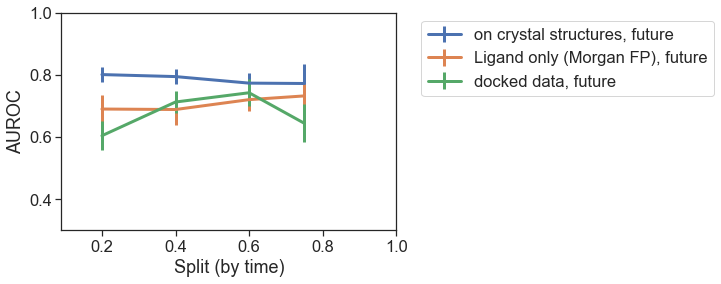

In [17]:
sns.set(font_scale=1.5) 
sns.set_style("ticks")
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5, yerr = test_auc_bootstrap_std_sc_bs5 / np.sqrt(1),
             label = 'on crystal structures, future', linewidth = 3)
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5_MFP, yerr = test_auc_bootstrap_std_sc_bs5_MFP / np.sqrt(1),
             label = 'Ligand only (Morgan FP), future', linewidth = 3)
plt.errorbar(time_split, test_auc_bootstrap_sc_bs5_dock, yerr = test_auc_bootstrap_dock_std / np.sqrt(1),
             label = 'docked data, future', linewidth = 3)
plt.xlim([0.09, 1])
plt.ylim([0.3, 1])
plt.xlabel('Split (by time)')
plt.ylabel('AUROC')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
plt.savefig('predict_future_100fold-btsp_NO_scfld_split.pdf')
plt.show()